# What do our likelihood surfaces look like?

Bayes:

$$ p(\theta | d) \propto p(d|\theta) \pi(\theta)$$

For a uniform prior, the posterior will look like the likelihood, modulo a normalization factor.

Lets see what some of our univariate likelihood curves look like (i.e. holding all other parameters constant)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
try:
    sys.path.remove("../py_src") # Hacky way to add higher directory to python modules path. 
except:
    pass
sys.path.append("../py_src") # Means that I dont have to make src/ a proper python package

In [4]:
from system_parameters import SystemParameters
from pulsars import Pulsars

from synthetic_data import SyntheticData
from plotting import plot_statespace,plot_all
from model import LinearModel
from kalman_filter import KalmanFilter
from bilby_wrapper import BilbySampler
from priors import priors_dict,bilby_priors_dict

### 1. Example system

***Welcome to the Kalman Filter Nested Sampler for PTA GW systems***
Attention: You are including the PSR terms in your synthetic data generation
No heterodyne corrections
Attention: You are using the Earth terms measurement model
Running the KF with non-heterodyned settings
1e-11
Ideal likelihood =  -12315351593.733387
Mean residual: -5.661401428543805e-10


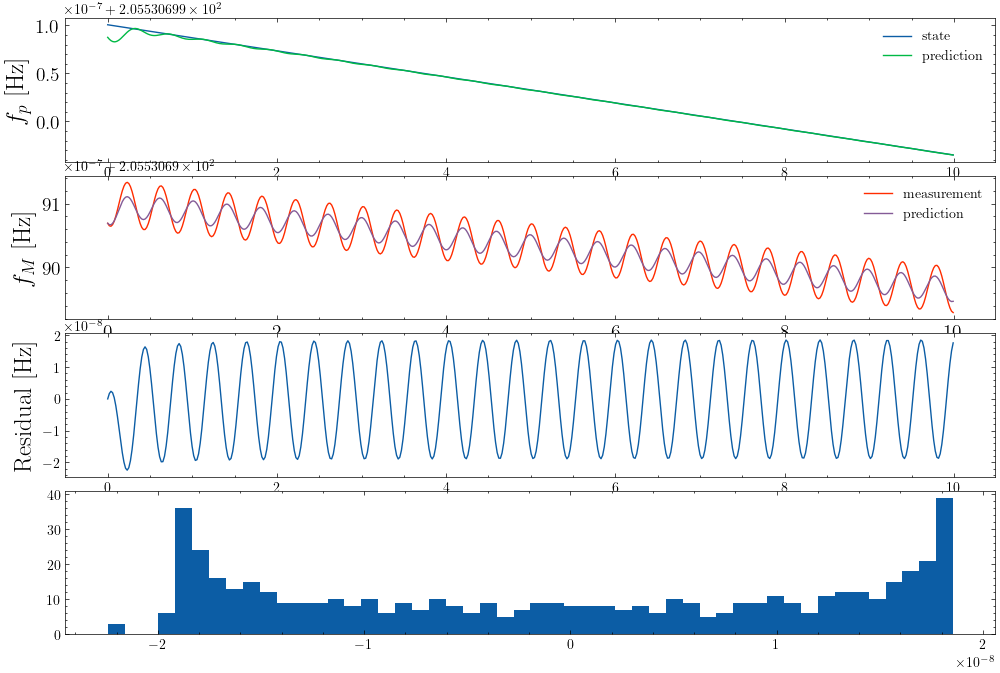

In [18]:
# Example Setup
P   = SystemParameters(h=1e-10,σp=0.0,σm=1e-11,use_psr_terms_in_data=True,measurement_model="earth")       # define the system parameters as a class
PTA = Pulsars(P)               #setup the PTA
data = SyntheticData(PTA,P) #generate some synthetic data


#Define the model 
model = LinearModel(P)


#Initialise the Kalman filter
KF = KalmanFilter(model,data.f_measured,PTA,P["heterodyne"], P["heterodyne_scale_factor"])


#Run the KF once with the correct parameters.
#This allows JIT precompile
guessed_parameters = priors_dict(PTA,P)
#guessed_parameters["sigma_m"] = PTA.sigma_m*1e13
print(guessed_parameters["sigma_m"])
model_likelihood,xres,yres = KF.likelihood(guessed_parameters)
print("Ideal likelihood = ", model_likelihood)
plot_all(PTA.t, data.intrinsic_frequency, data.f_measured, xres,yres, 1,savefig=None)


---


### 2. Likelihood curves

In [19]:
from plotting import iterate_over_priors


import matplotlib.pyplot as plt 
def plot_likelihood(x,y,x_logscale,y_logscale,variable_name,x_critical):

    h,w = 12,8
    rows = 1
    cols = 1
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(h,w),sharex=False)

    ax.plot(x,y)

    if x_logscale:
        ax.set_xscale('log')
    if y_logscale:
        ax.set_yscale('log')

    ax.axvline(x_critical,linestyle='--', c='C2')

    ax.set_xlabel(variable_name)
    ax.set_ylabel("likelihood")

    plt.show()



---


#### 2.1 GW source declination - $\delta$ 

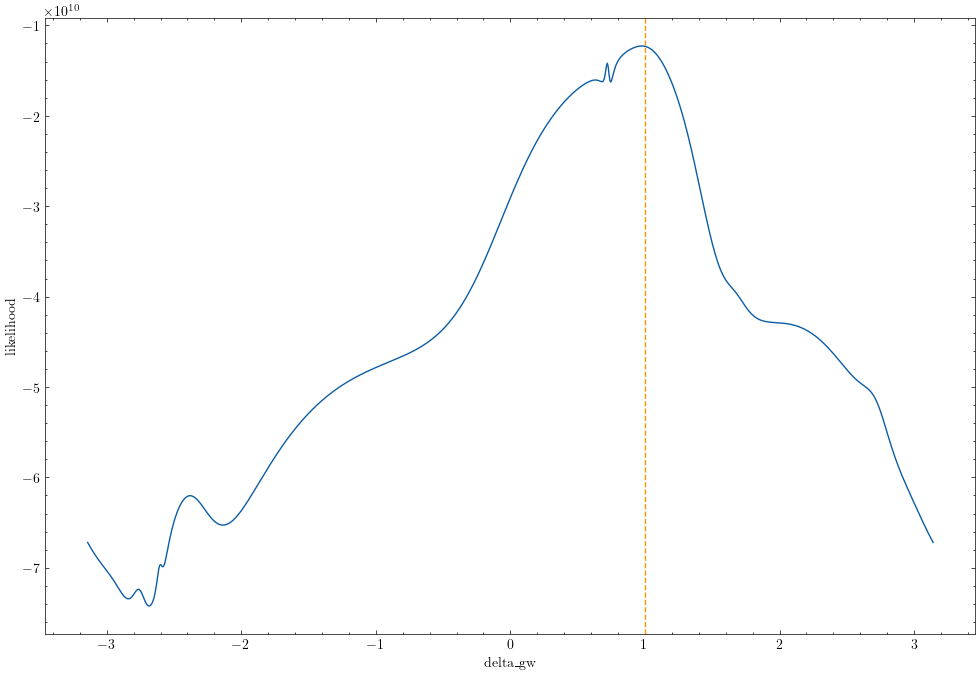

In [20]:
import numpy as np 
variable = "delta_gw"
variable_range = np.linspace(-np.pi,np.pi,int(1e3))
likelihoods = iterate_over_priors(variable, variable_range,guessed_parameters,KF)
plot_likelihood(variable_range,likelihoods,False,False,variable,guessed_parameters[variable])


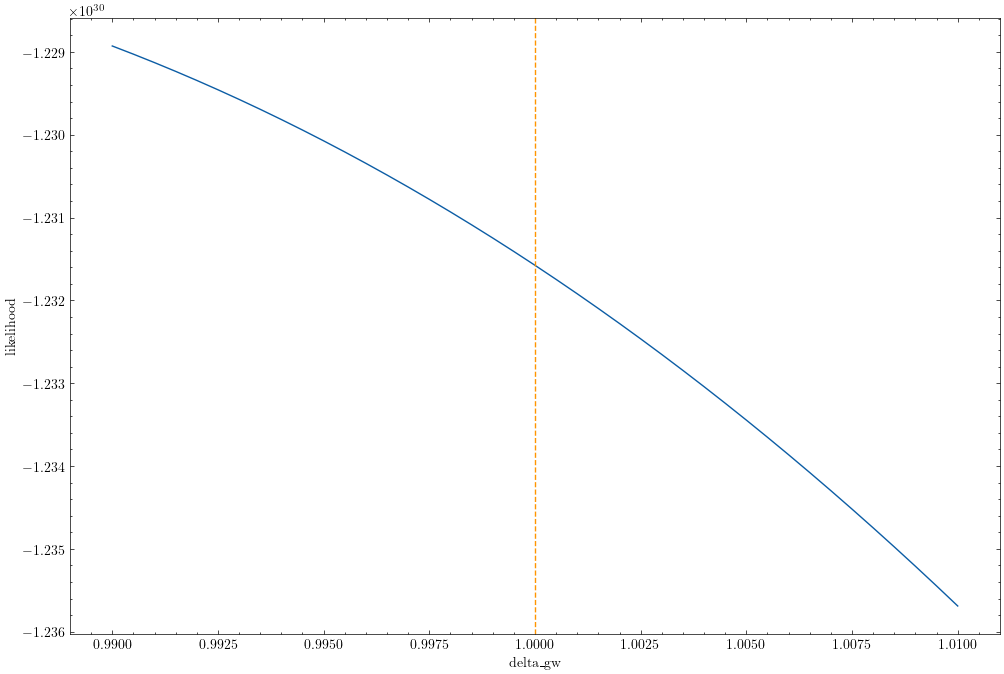

In [7]:
variable = "delta_gw"
variable_range = np.arange(0.99,1.01,0.0001)
likelihoods = iterate_over_priors(variable, variable_range,guessed_parameters,KF)
plot_likelihood(variable_range,likelihoods,False,False,variable,guessed_parameters[variable])


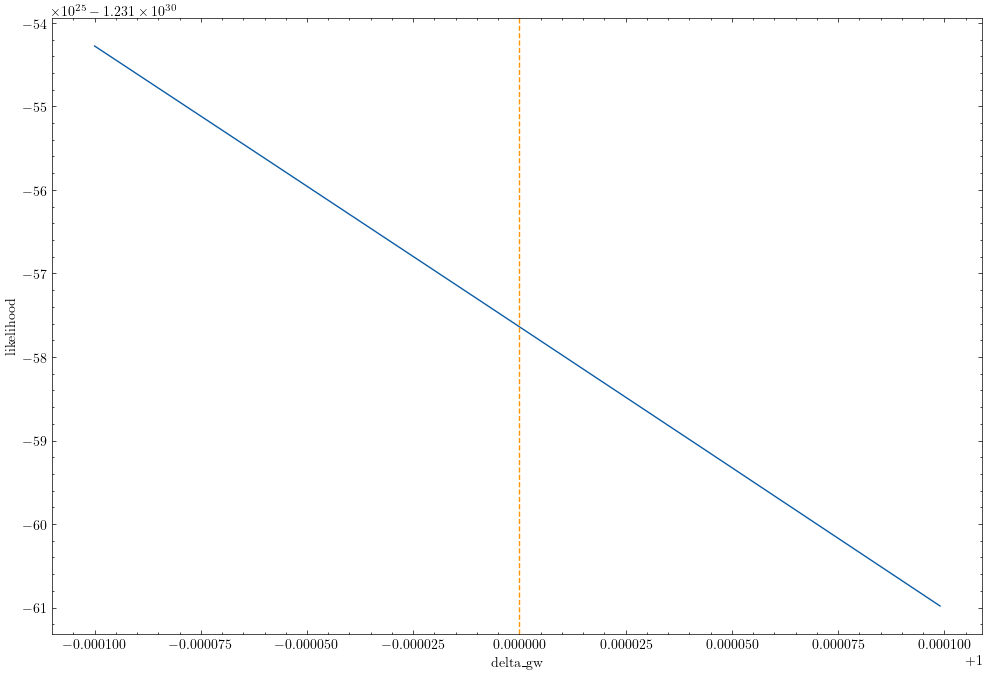

In [8]:
variable = "delta_gw"
eps = 1e-4
variable_range = np.arange(1.0-eps,1.0+eps,eps/100.0)
likelihoods = iterate_over_priors(variable, variable_range,guessed_parameters,KF)
plot_likelihood(variable_range,likelihoods,False,False,variable,guessed_parameters[variable])


---


#### 2.2 GW source angular frequency - $\omega$ 

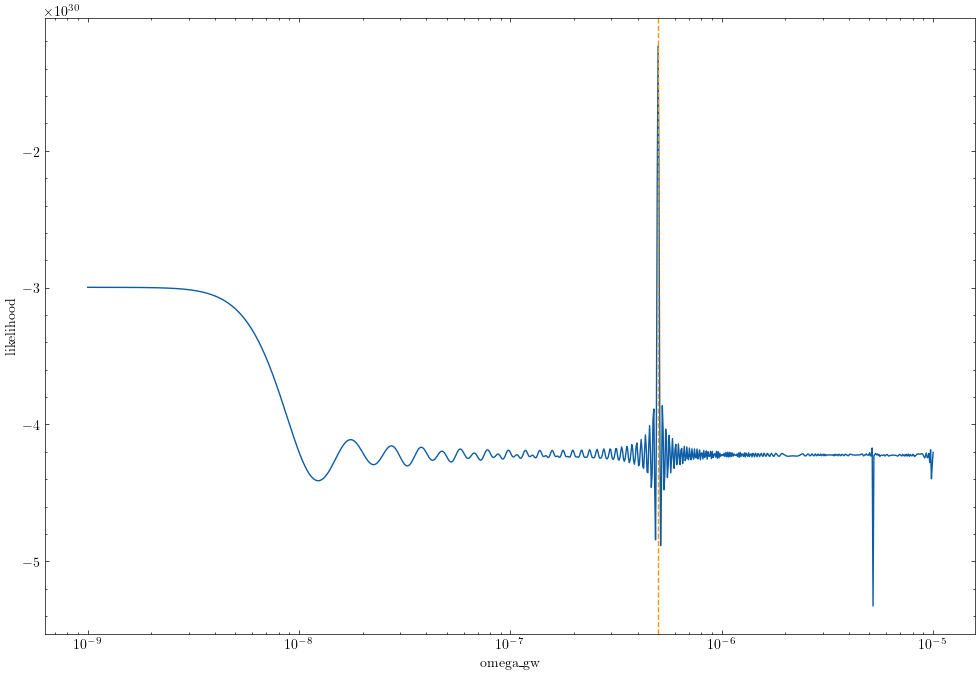

In [9]:
variable = "omega_gw"
variable_range = np.logspace(-9,-5,int(1e3))
likelihoods = iterate_over_priors(variable, variable_range,guessed_parameters,KF)
plot_likelihood(variable_range,likelihoods,True,False,variable,guessed_parameters[variable])


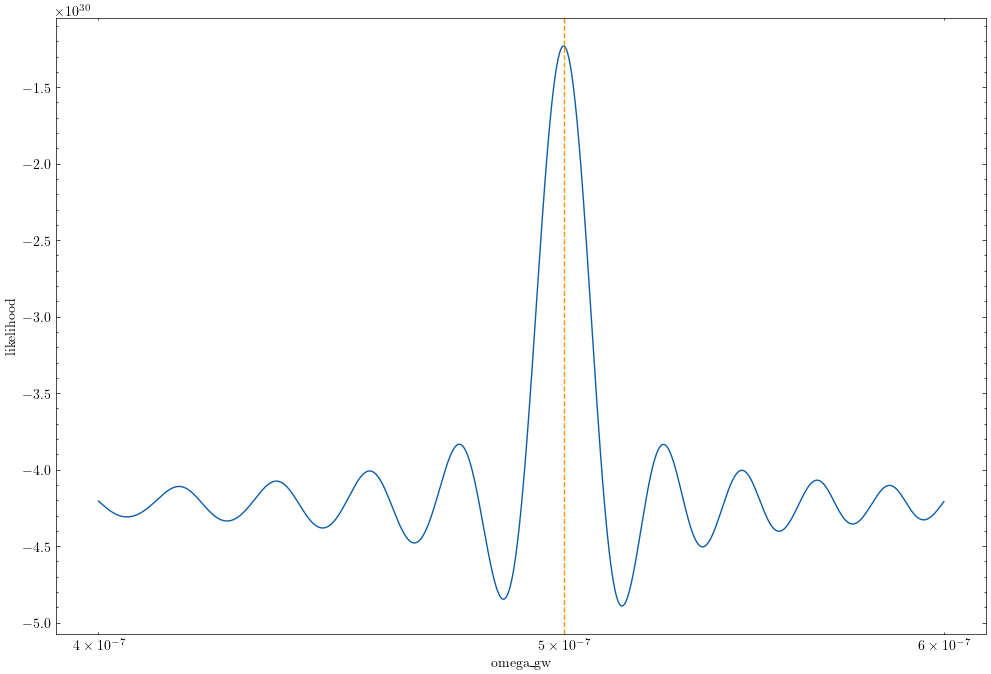

In [10]:
variable = "omega_gw"
variable_range = np.arange(4e-7,6e-7,1e-10)
likelihoods = iterate_over_priors(variable, variable_range,guessed_parameters,KF)
plot_likelihood(variable_range,likelihoods,True,False,variable,guessed_parameters[variable])


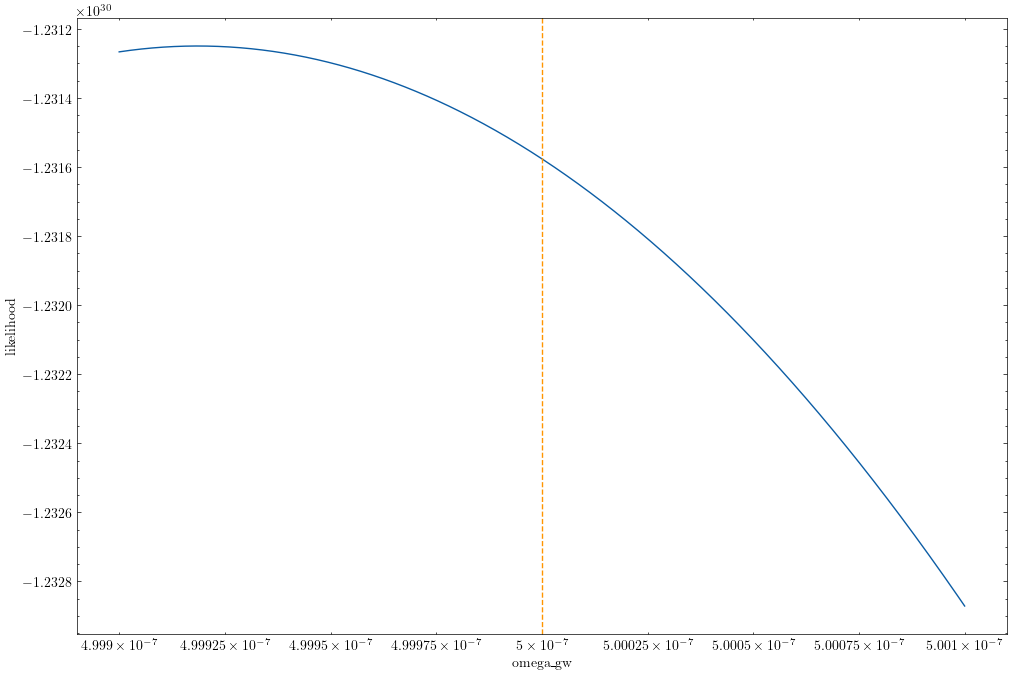

In [11]:
variable = "omega_gw"
eps = 1e-10
variable_range = np.arange(5e-7-eps,5e-7+eps,eps/500.0)
likelihoods = iterate_over_priors(variable, variable_range,guessed_parameters,KF)
plot_likelihood(variable_range,likelihoods,True,False,variable,guessed_parameters[variable])


#### 2.3 GW source phase offset - $\Phi_0$

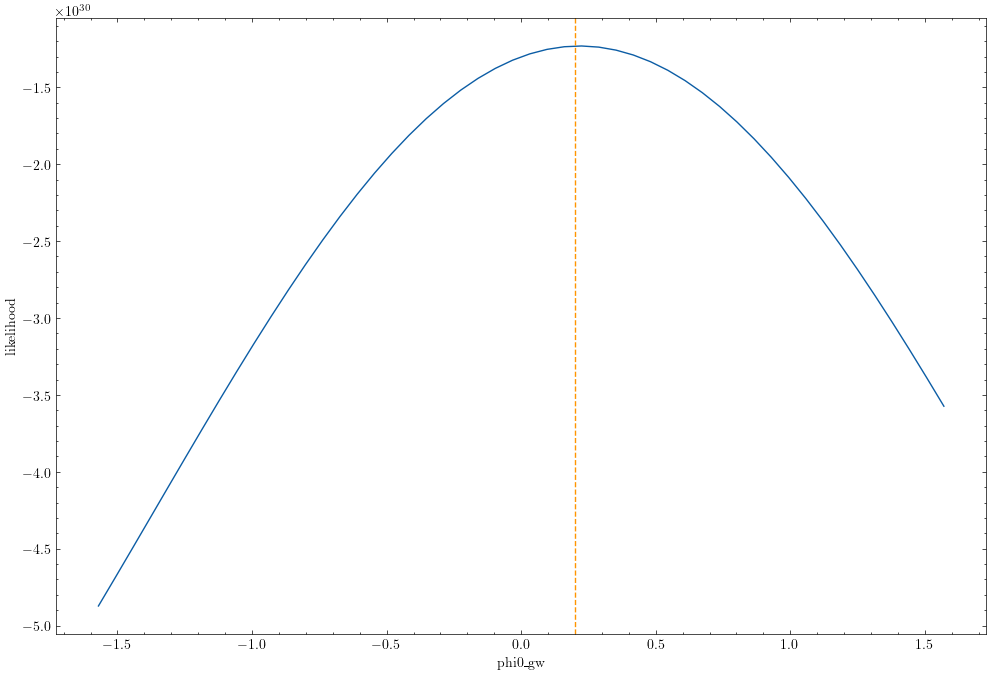

In [12]:
variable = "phi0_gw"
variable_range = np.linspace(-np.pi/2,np.pi/2)
likelihoods = iterate_over_priors(variable, variable_range,guessed_parameters,KF)
plot_likelihood(variable_range,likelihoods,False,False,variable,guessed_parameters[variable])


### 3. All likelihood curves for $\bar{\theta}_{GW}$

0 omega_gw 5e-07
1 psi_gw 2.5
2 phi0_gw 0.2
3 iota_gw 1.0
4 delta_gw 1.0
5 alpha_gw 1.0
6 h 0.01


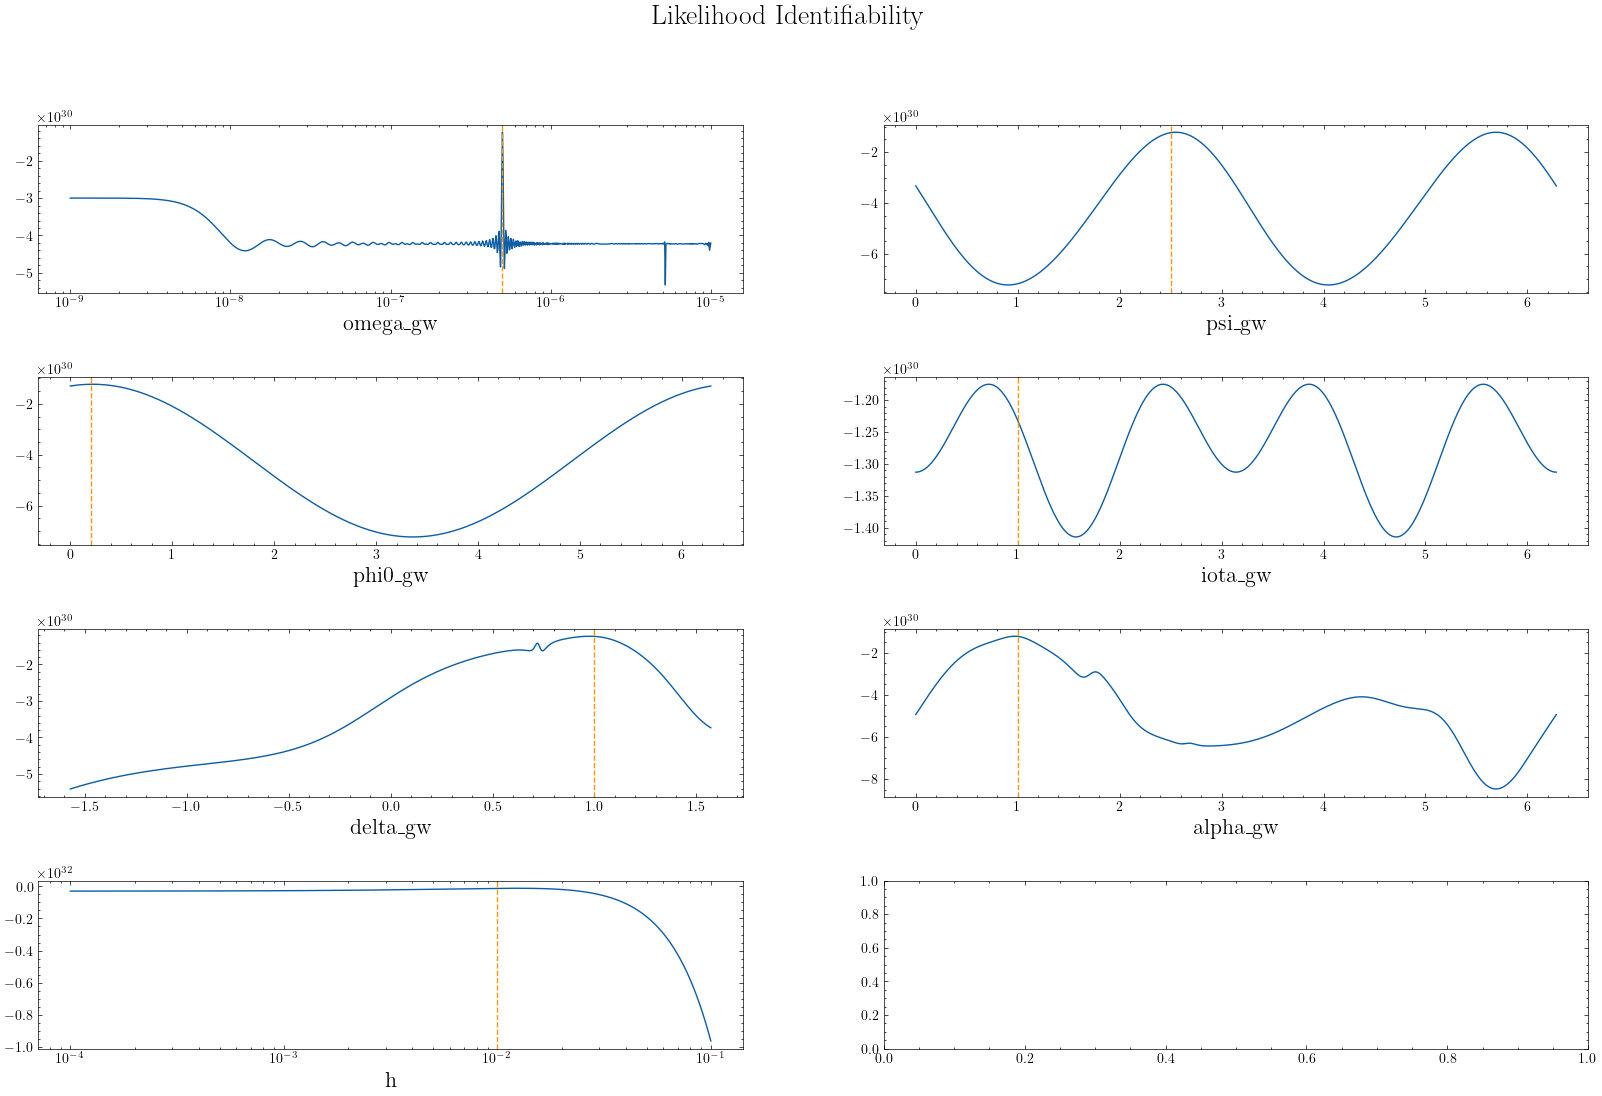

In [13]:
selected_parameters = ["omega_gw",
                       "psi_gw",
                        "phi0_gw",
                        "iota_gw",
                        "delta_gw",
                        "alpha_gw",
                        "h"]
parameters_dict = {k: guessed_parameters[k] for k in selected_parameters}


nsamples = int(1e3)

priors = [np.logspace(-9,-5,nsamples),                   # omega
          np.linspace(0,2*np.pi,nsamples),               # psi
          np.linspace(0,2*np.pi,nsamples),               # phi0
          np.linspace(0,2*np.pi,nsamples),               # iota
          np.linspace(-np.pi/2.0,np.pi/2.0,nsamples),    # delta
          np.linspace(0,2*np.pi,nsamples),               # alpha
          np.logspace(-4,-1,nsamples),                   # h
]

from plotting import likelihoods_over_priors
likelihoods_over_priors(parameters_dict,priors,PTA,P,KF)
